<a href="https://colab.research.google.com/github/prosperjohn9/web_traffic_analysis/blob/main/WebTrafficAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
!pip install statsmodels

In [188]:
!pip install prophet

Web Traffic Analysis and Prediction.

In [189]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from joblib import Parallel, delayed
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from matplotlib.dates import DateFormatter, MonthLocator
from google.colab import drive

# Suppressing warnings to make output cleaner
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/daily-website-visitors.csv")

# Show dataset
data

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236
...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,8/15/2020,"2,221","1,696","1,373",323
2163,2164,Sunday,1,8/16/2020,"2,724","2,037","1,686",351
2164,2165,Monday,2,8/17/2020,"3,456","2,638","2,181",457
2165,2166,Tuesday,3,8/18/2020,"3,581","2,683","2,184",499


In [190]:
# Display summary statistics
print(data.describe())

               Row  Day.Of.Week
count  2167.000000  2167.000000
mean   1084.000000     3.997231
std     625.703338     2.000229
min       1.000000     1.000000
25%     542.500000     2.000000
50%    1084.000000     4.000000
75%    1625.500000     6.000000
max    2167.000000     7.000000


In [191]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB
None


Data Preprocessing and Analysis: Apply data mining techniques such as Exploratory Data Analysis (EDA)
 and time series analysis to preprocess, clean and analyze the collected website traffic data.

In [192]:
# Data Preprocessing
# Remove commas and convert to numeric
cols_to_convert = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col].str.replace(',', ''), errors='coerce')

# Handle missing data
data = data.fillna(method='ffill')

# Check the conversions
print(data[cols_to_convert].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Page.Loads         2167 non-null   int64
 1   Unique.Visits      2167 non-null   int64
 2   First.Time.Visits  2167 non-null   int64
 3   Returning.Visits   2167 non-null   int64
dtypes: int64(4)
memory usage: 67.8 KB
None


In [193]:
# Convert 'Date' to datetime and extract features
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Weekday'] = data['Date'].dt.weekday  # 0 = Monday, 6 = Sunday
data['Is_Weekend'] = data['Weekday'].isin([5, 6]).astype(int)  # 1 for Weekend, 0 for Weekday

# Display the enhanced data frame
data

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Weekday,Is_Weekend
0,1,Sunday,1,2014-09-14,2146,1582,1430,152,9,2014,6,1
1,2,Monday,2,2014-09-15,3621,2528,2297,231,9,2014,0,0
2,3,Tuesday,3,2014-09-16,3698,2630,2352,278,9,2014,1,0
3,4,Wednesday,4,2014-09-17,3667,2614,2327,287,9,2014,2,0
4,5,Thursday,5,2014-09-18,3316,2366,2130,236,9,2014,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2162,2163,Saturday,7,2020-08-15,2221,1696,1373,323,8,2020,5,1
2163,2164,Sunday,1,2020-08-16,2724,2037,1686,351,8,2020,6,1
2164,2165,Monday,2,2020-08-17,3456,2638,2181,457,8,2020,0,0
2165,2166,Tuesday,3,2020-08-18,3581,2683,2184,499,8,2020,1,0


**Exploratory Data Analysis (EDA)**

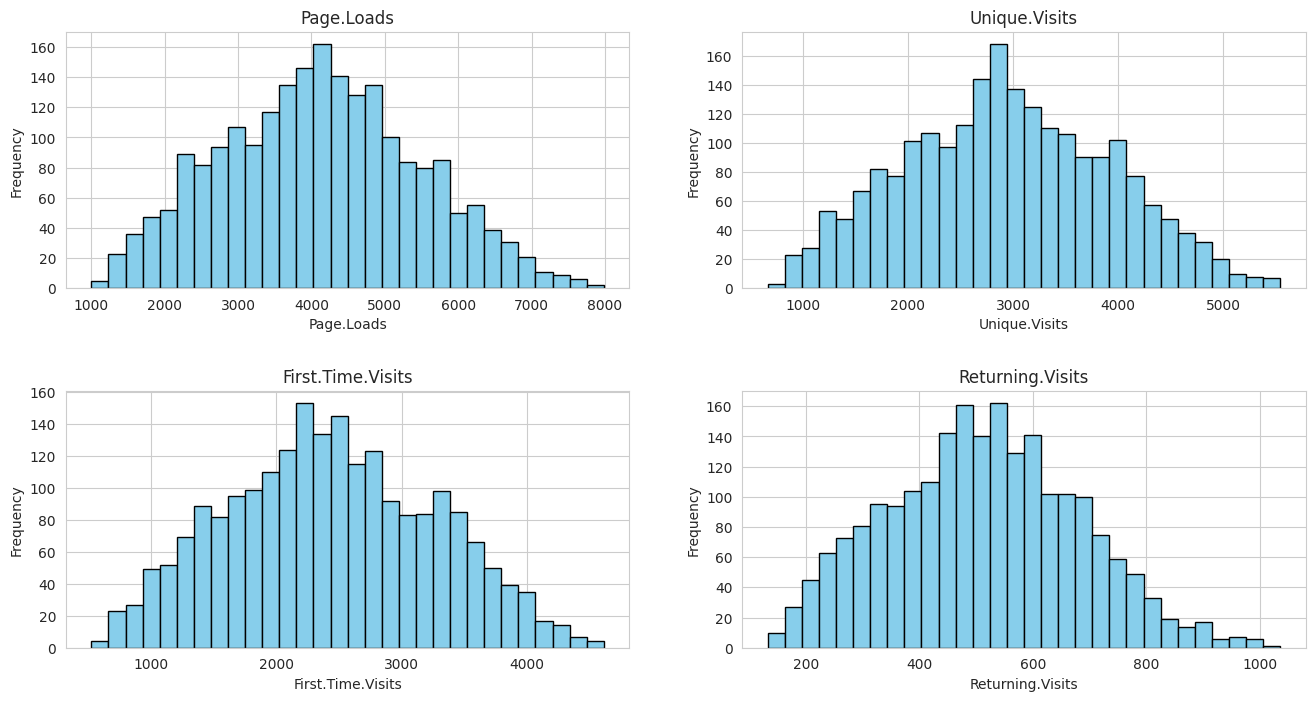

In [194]:
# Advanced Exploratory Data Analysis (EDA)
# Plot histograms for numeric features to check distributions
axes = data[cols_to_convert].hist(figsize=(16, 8), bins=30, layout=(2, 2), color='skyblue', edgecolor='black')
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Add x-axis and y-axis labels to each subplot
for ax, name in zip(axes.flatten(), cols_to_convert):
    ax.set_xlabel(name)
    ax.set_ylabel('Frequency')

plt.show()

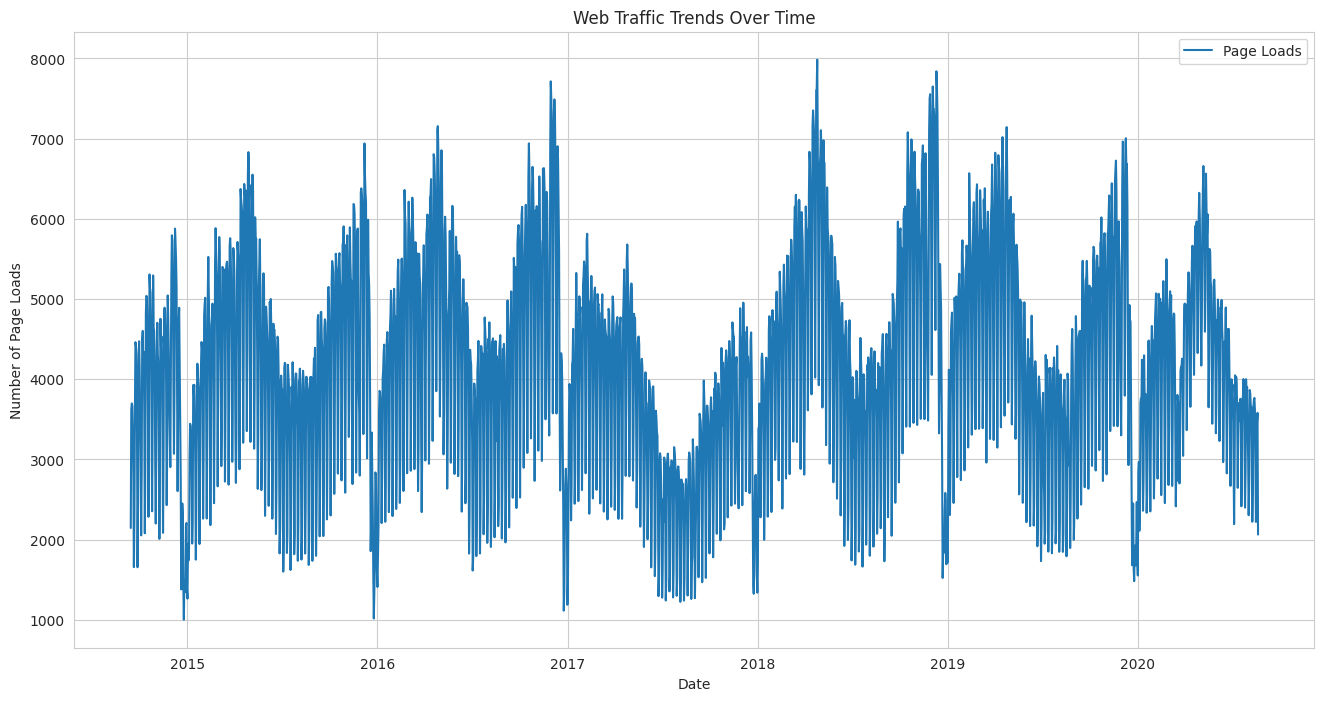

In [195]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting Page Loads over time (Time Series Plot)
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Page.Loads'], label='Page Loads')
plt.title('Web Traffic Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Page Loads')
plt.legend()
plt.show()

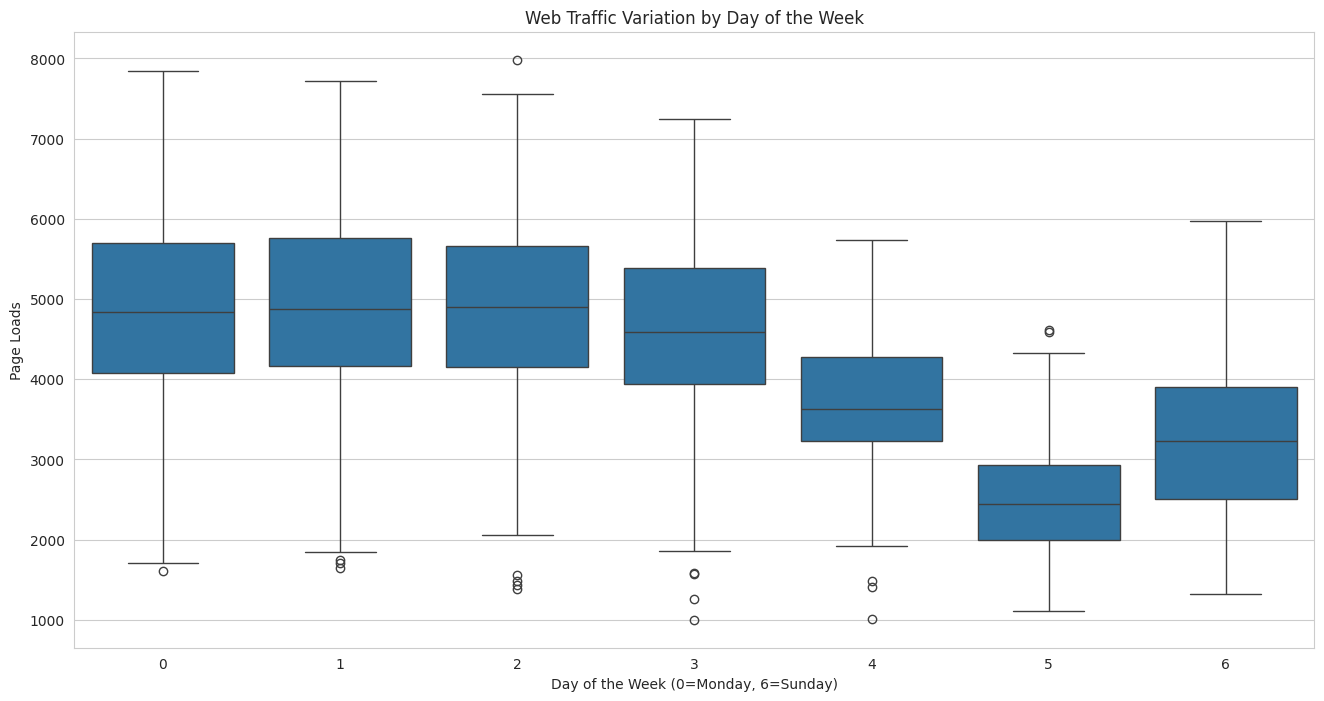

In [196]:
# Page Loads by Day of the Week
plt.figure(figsize=(16, 8))
sns.boxplot(x='Weekday', y='Page.Loads', data=data)
plt.title('Web Traffic Variation by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Page Loads')
plt.show()

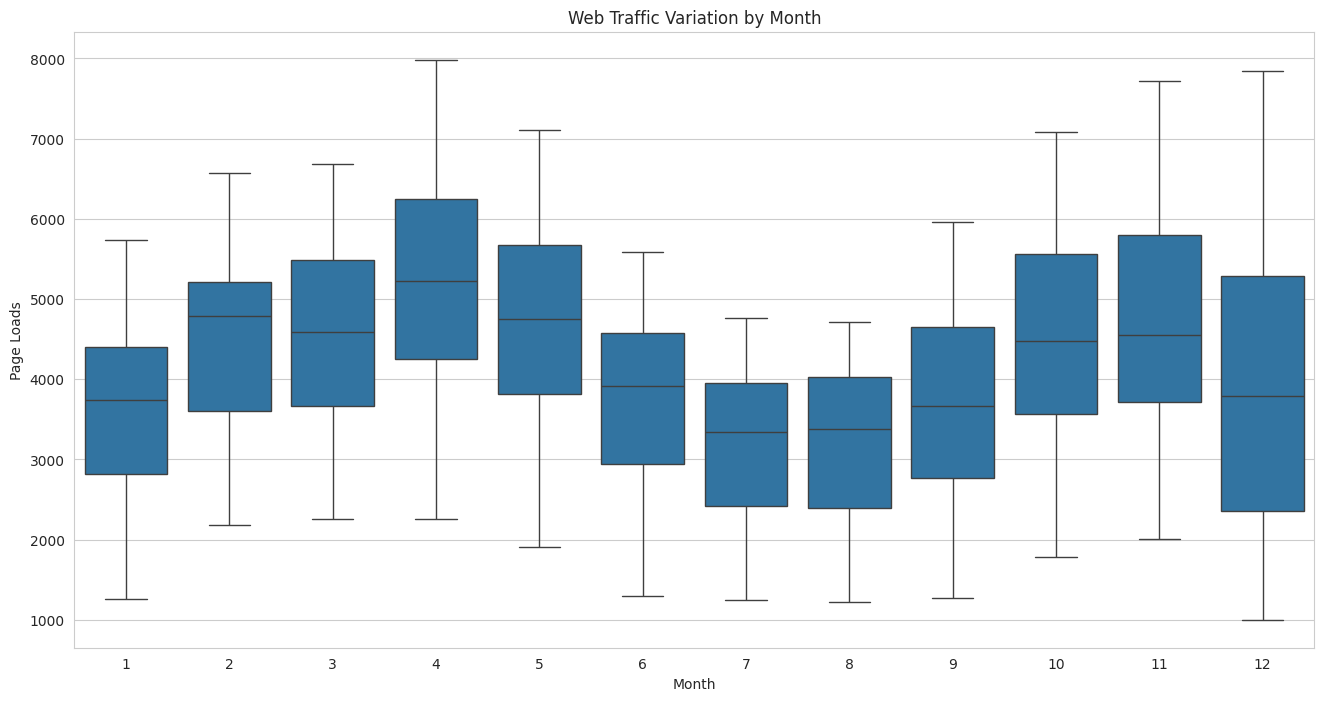

In [197]:
# Page Loads by Month
plt.figure(figsize=(16, 8))
sns.boxplot(x='Month', y='Page.Loads', data=data)
plt.title('Web Traffic Variation by Month')
plt.xlabel('Month')
plt.ylabel('Page Loads')
plt.show()

Pattern and Trend Identification: Identify meaningful patterns, trends and anomalies in the website traffic data to uncover valuable insights for the website.

**Time Series Decomposition**

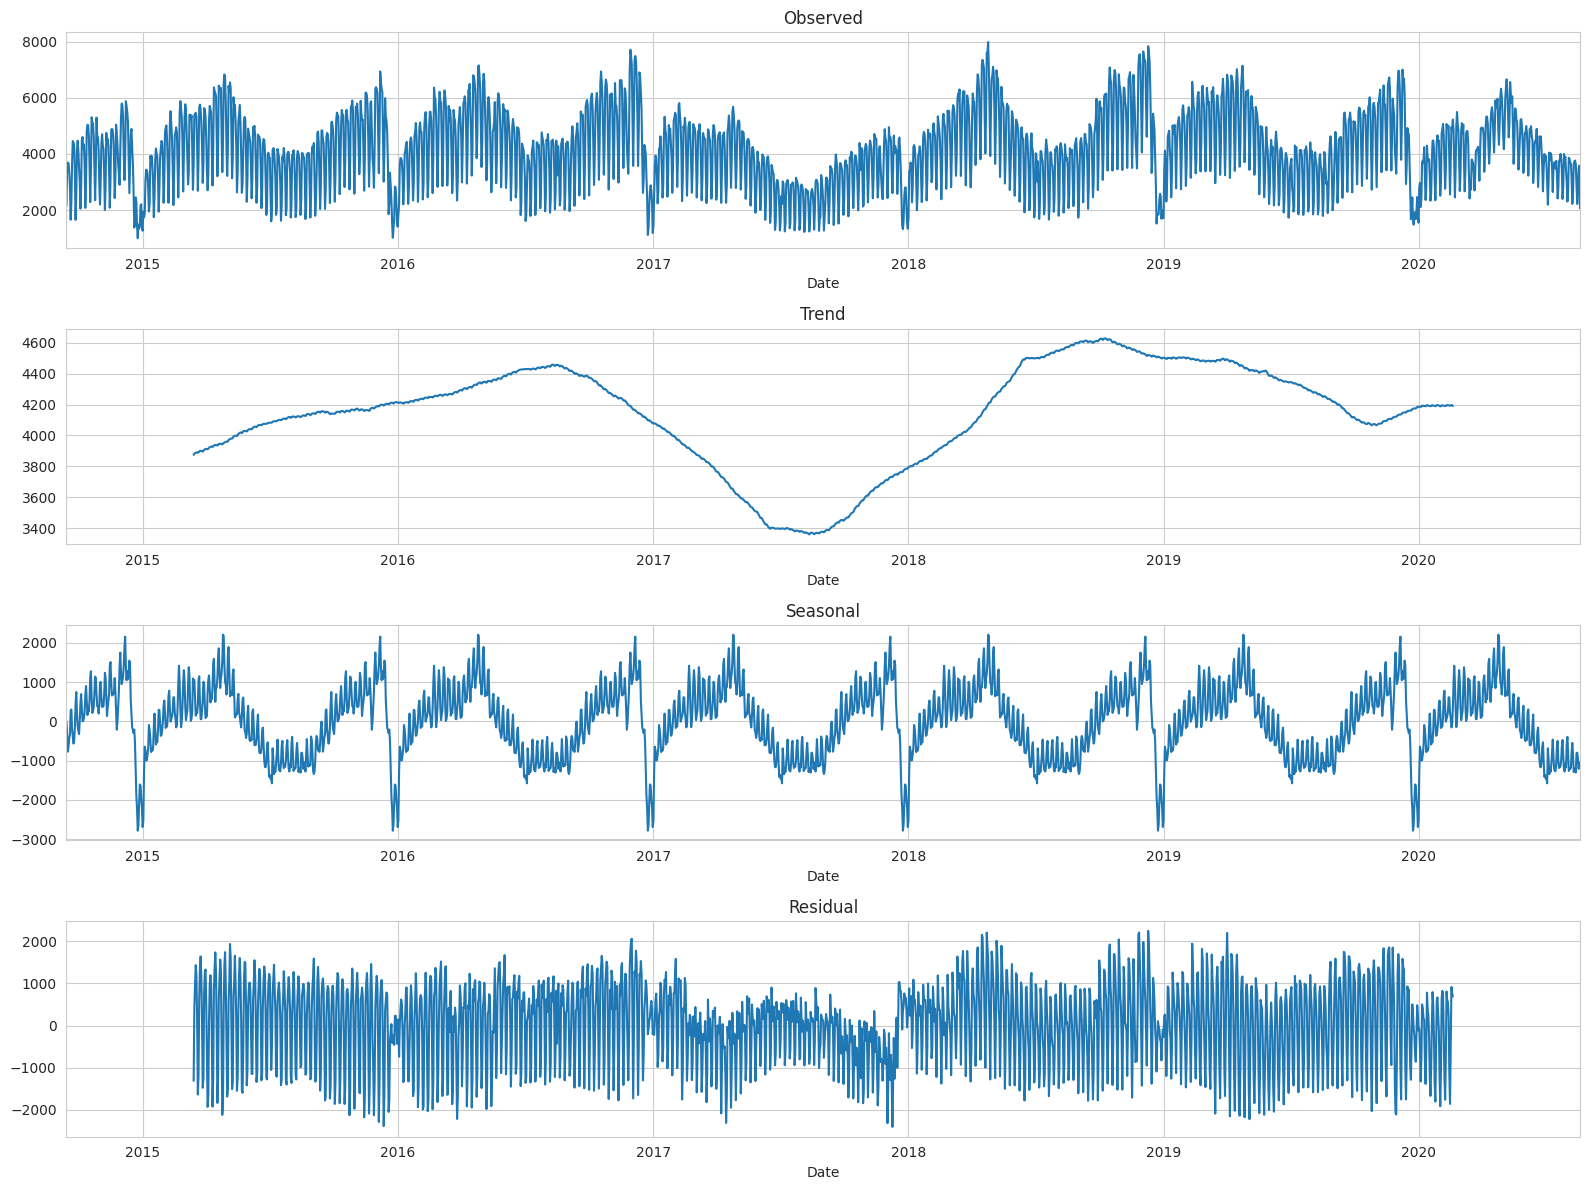

In [198]:
# Ensure your 'Date' column is set as the DataFrame index
data.set_index('Date', inplace=True)

# Decompose the time series
decomposition = seasonal_decompose(data['Page.Loads'], model='additive', period=365)  # Assuming 365 days in a year

# Create a figure with matplotlib and set the size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))  # Creating a 4-row subplot structure

# Plot the original(Page Loads), trend, seasonal, and residual components
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

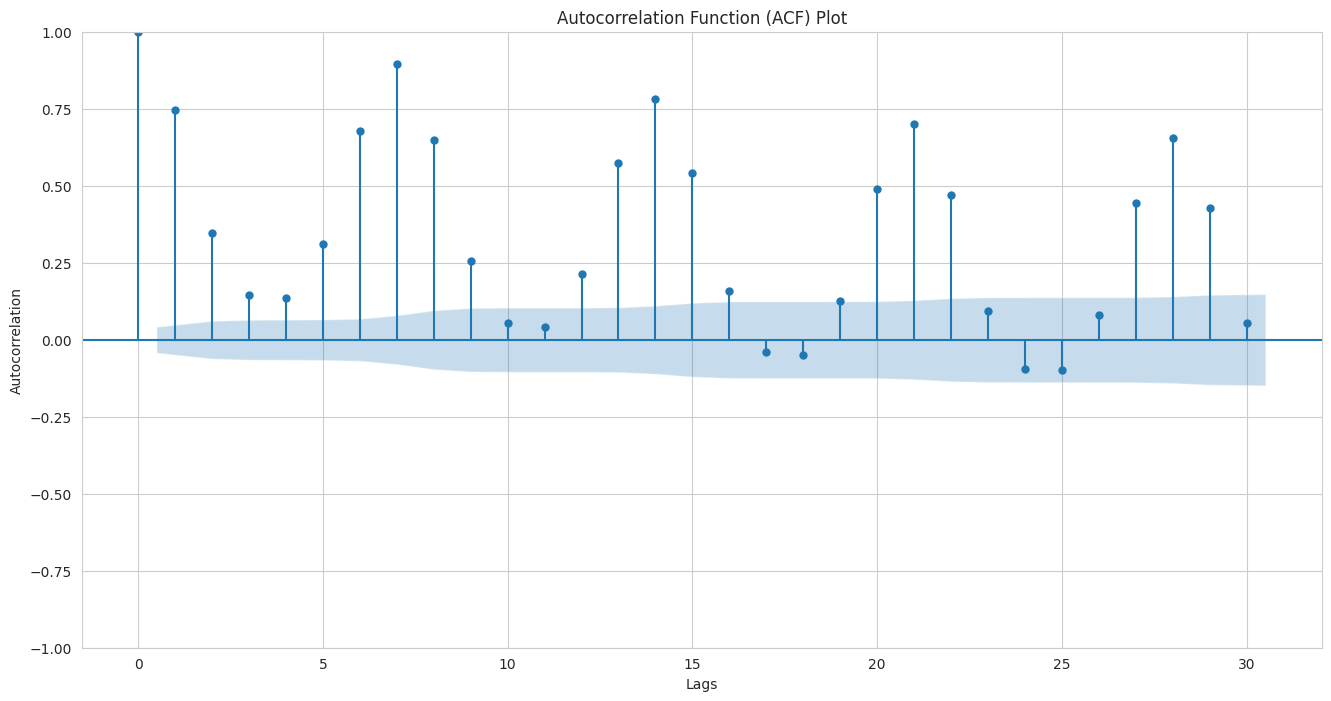

In [199]:
# ACF plot
fig, ax = plt.subplots(figsize=(16, 8))
plot_acf(data['Page.Loads'], lags=30, ax=ax)

# Label the axes
ax.set_xlabel('Lags')         # Horizontal axis label indicating the number of lags
ax.set_ylabel('Autocorrelation')  # Vertical axis label indicating the correlation values

# Add a title if needed
ax.set_title('Autocorrelation Function (ACF) Plot')

# Show the plot
plt.show()

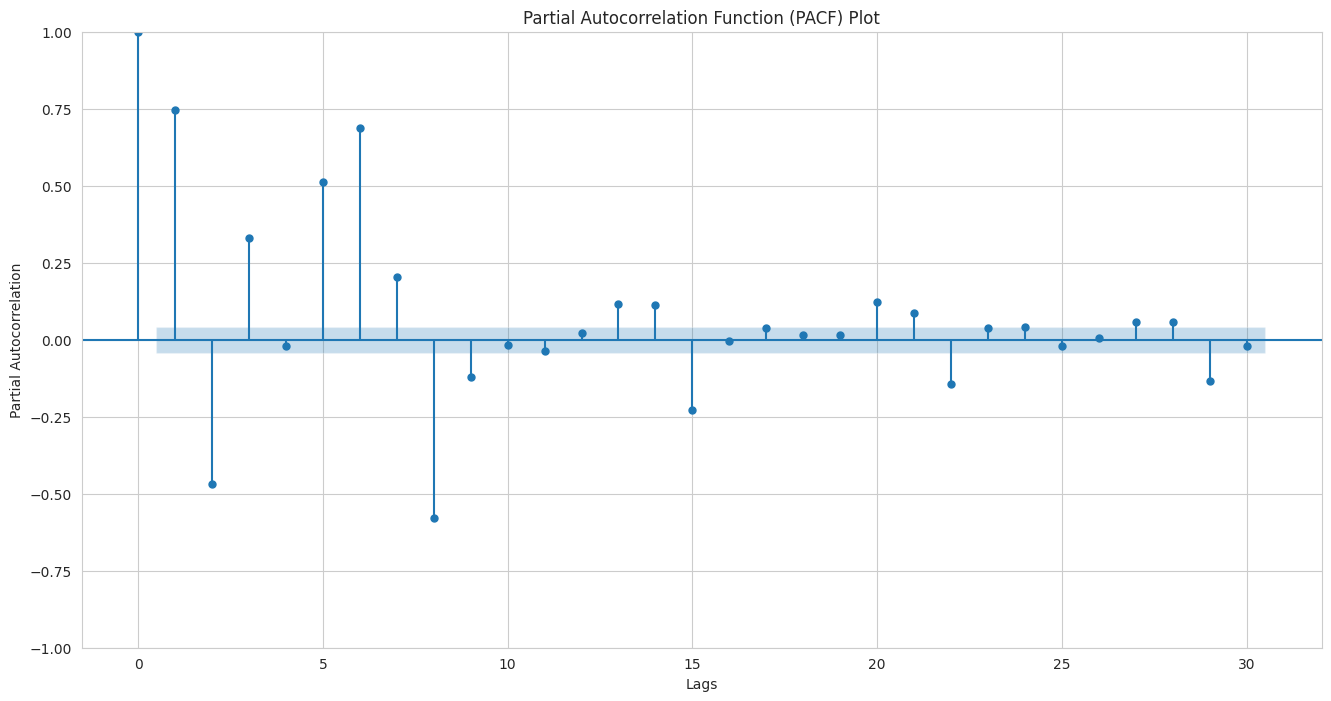

In [200]:
# PACF plot
fig, ax = plt.subplots(figsize=(16, 8))
plot_pacf(data['Page.Loads'], lags=30, ax=ax)

# Label the axes
ax.set_xlabel('Lags')
ax.set_ylabel('Partial Autocorrelation')
ax.set_title('Partial Autocorrelation Function (PACF) Plot')

# Show the plot
plt.show()

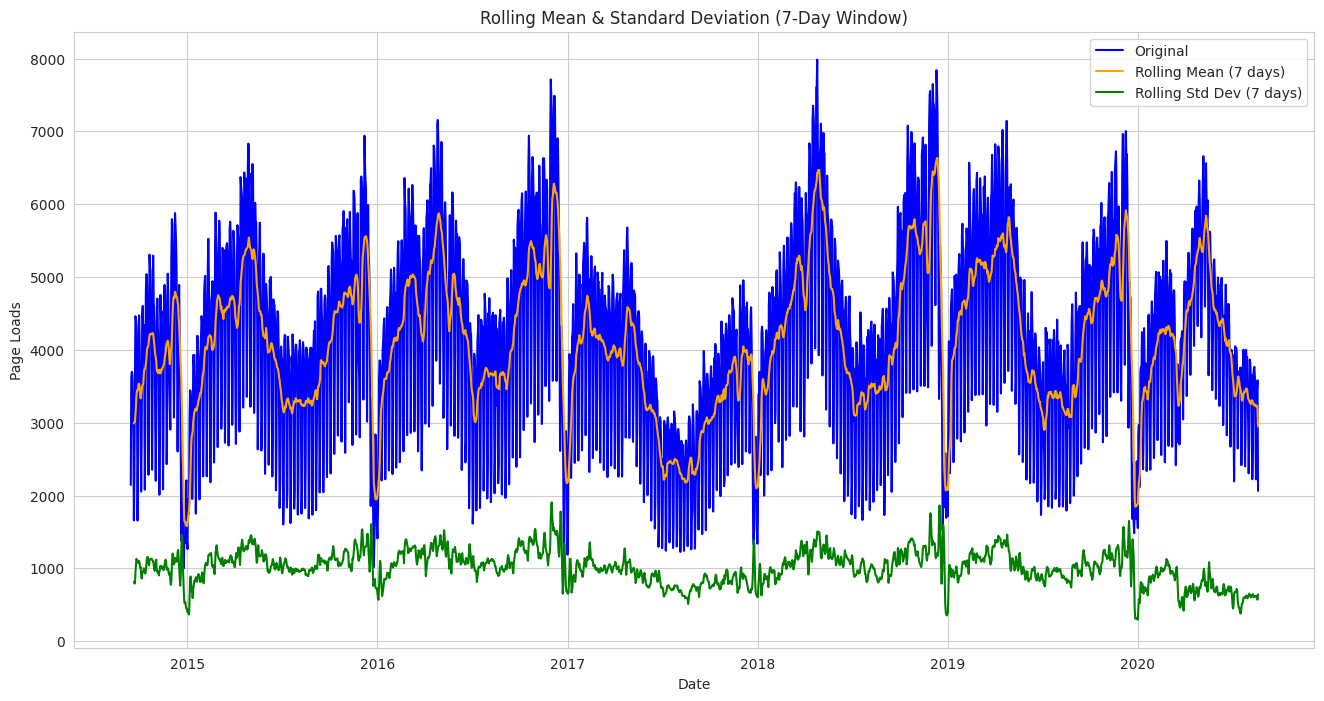

In [201]:
# Rolling Statistics for Trend Analysis
rolling_window = 7  # 7-day window for weekly trend analysis
data['Rolling_Mean'] = data['Page.Loads'].rolling(window=rolling_window).mean()
data['Rolling_Std'] = data['Page.Loads'].rolling(window=rolling_window).std()

# Plot the original 'Page Loads' along with rolling mean and standard deviation
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['Page.Loads'], label='Original', color='blue')
plt.plot(data.index, data['Rolling_Mean'], label='Rolling Mean (7 days)', color='orange')
plt.plot(data.index, data['Rolling_Std'], label='Rolling Std Dev (7 days)', color='green')
plt.legend(loc='best')

# Label the axes and add a title
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Rolling Mean & Standard Deviation (7-Day Window)')

# Show the plot
plt.show()

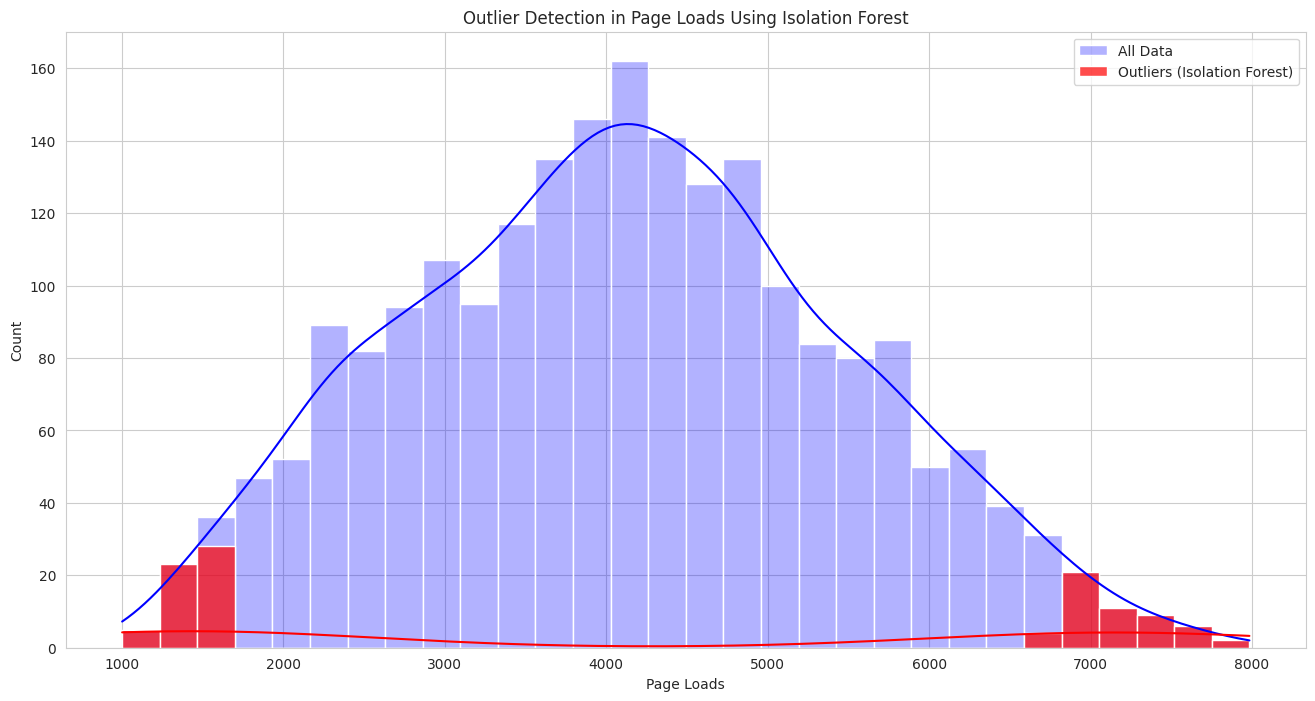

In [202]:
# Isolation Forest based outlier detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = iso_forest.fit_predict(data[['Page.Loads']])

# Isolate outliers
data['Iso_Outliers'] = outlier_predictions
outliers_iso = data[data['Iso_Outliers'] == -1]

plt.figure(figsize=(16, 8))
sns.histplot(data['Page.Loads'], bins=30, kde=True, label='All Data', color='blue', alpha=0.3)
sns.histplot(outliers_iso['Page.Loads'], bins=30, kde=True, label='Outliers (Isolation Forest)', color='red', alpha=0.7)
plt.title('Outlier Detection in Page Loads Using Isolation Forest')
plt.xlabel('Page Loads')
plt.legend()
plt.show()

Predictive Modeling: Developing predictive models for future traffic forecasting.

Parameter Grid Search

In [203]:
# Define the parameter range for p (AR terms), d (differencing), and q (MA terms)
p = d = q = range(0, 3)

# Create all possible combinations of p, d, q with fixed d=1 for differencing
pdq = list(itertools.product(p, [1], q))

# Iterate through each combination of (p, d, q) parameters
for param in pdq:
    try:
        # Initialize and fit an ARIMA model with the given parameters
        model = ARIMA(data['Page.Loads'].iloc[:-365], order=param) # Using all data except the last year
        fitted_model = model.fit()

        # Output the current parameter combination and its corresponding AIC
        print('ARIMA{} - AIC:{}'.format(param, fitted_model.aic))
    except:
        # Continue to the next iteration if the model fitting fails for any combination
        continue

ARIMA(0, 1, 0) - AIC:29958.1798983896
ARIMA(0, 1, 1) - AIC:29480.506136413234
ARIMA(0, 1, 2) - AIC:29078.09795843273
ARIMA(1, 1, 0) - AIC:29805.580290571583
ARIMA(1, 1, 1) - AIC:29456.241305276082
ARIMA(1, 1, 2) - AIC:28933.64069742363
ARIMA(2, 1, 0) - AIC:29257.615754327555
ARIMA(2, 1, 1) - AIC:28720.27413306413
ARIMA(2, 1, 2) - AIC:28224.73503360994


In [204]:
# Define the model using the training data
# Using parameters generated by ACF/PACF analysis and iterative modeling
model = ARIMA(data['Page.Loads'].iloc[:-365], order=(2,1,2))  # Using data excluding the last year to fit the model

# Fit the model
fitted_model = model.fit()

# Check the summary of the model to understand the fit
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Page.Loads   No. Observations:                 1802
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14107.368
Date:                Thu, 09 May 2024   AIC                          28224.735
Time:                        08:16:11   BIC                          28252.216
Sample:                    09-14-2014   HQIC                         28234.879
                         - 08-20-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2123      0.009    136.789      0.000       1.195       1.230
ar.L2         -0.9455      0.007   -128.857      0.000      -0.960      -0.931
ma.L1         -1.4409      0.015    -94.175      0.0

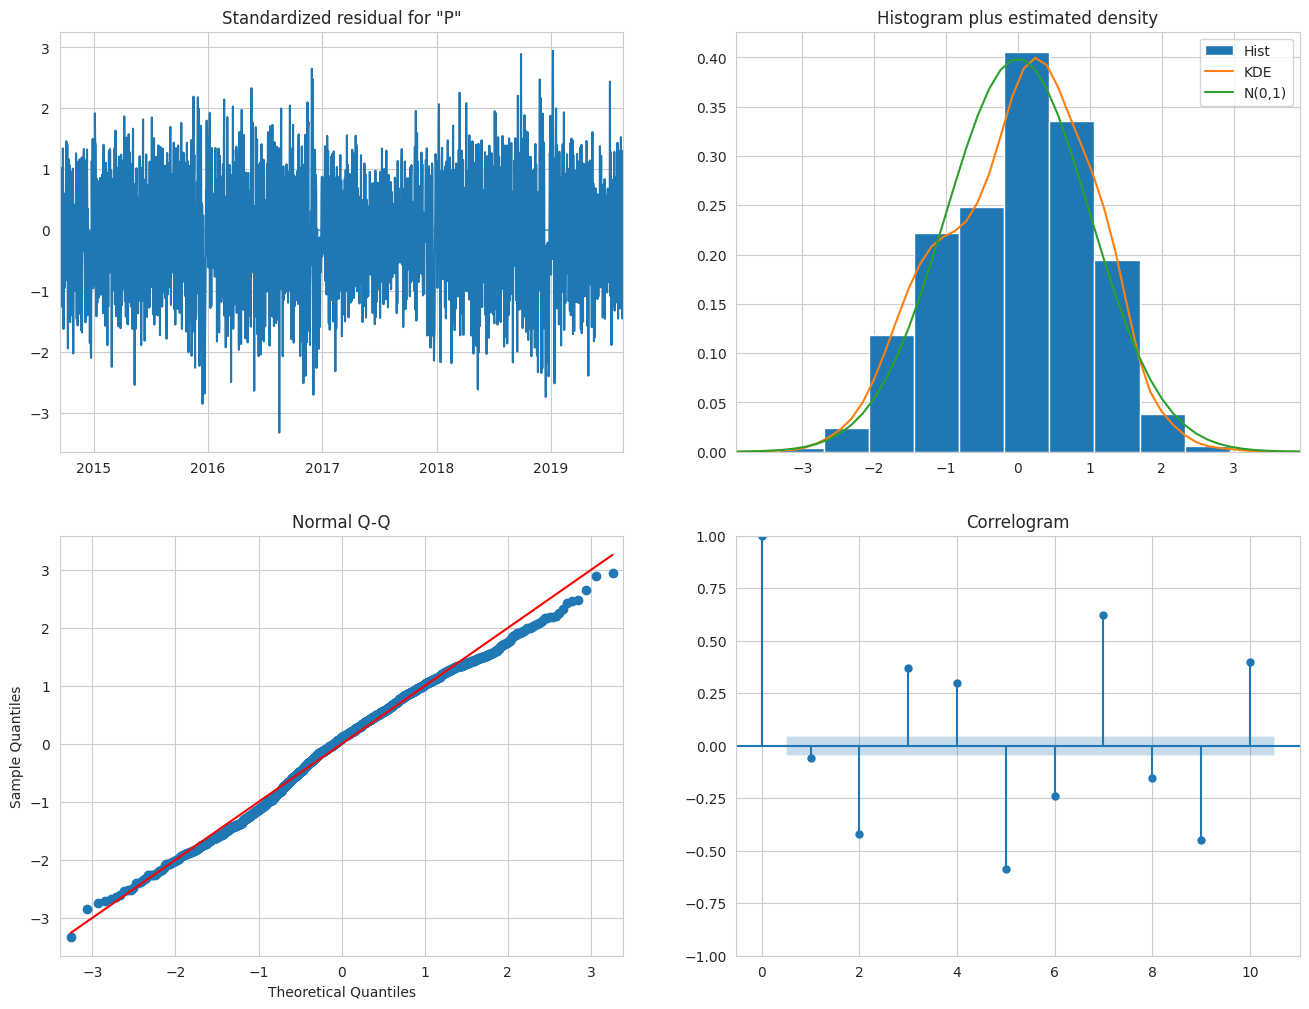

In [205]:
# Model Diagnostics to check for any unusual behavior
fitted_model.plot_diagnostics(figsize=(16, 12))
plt.show()

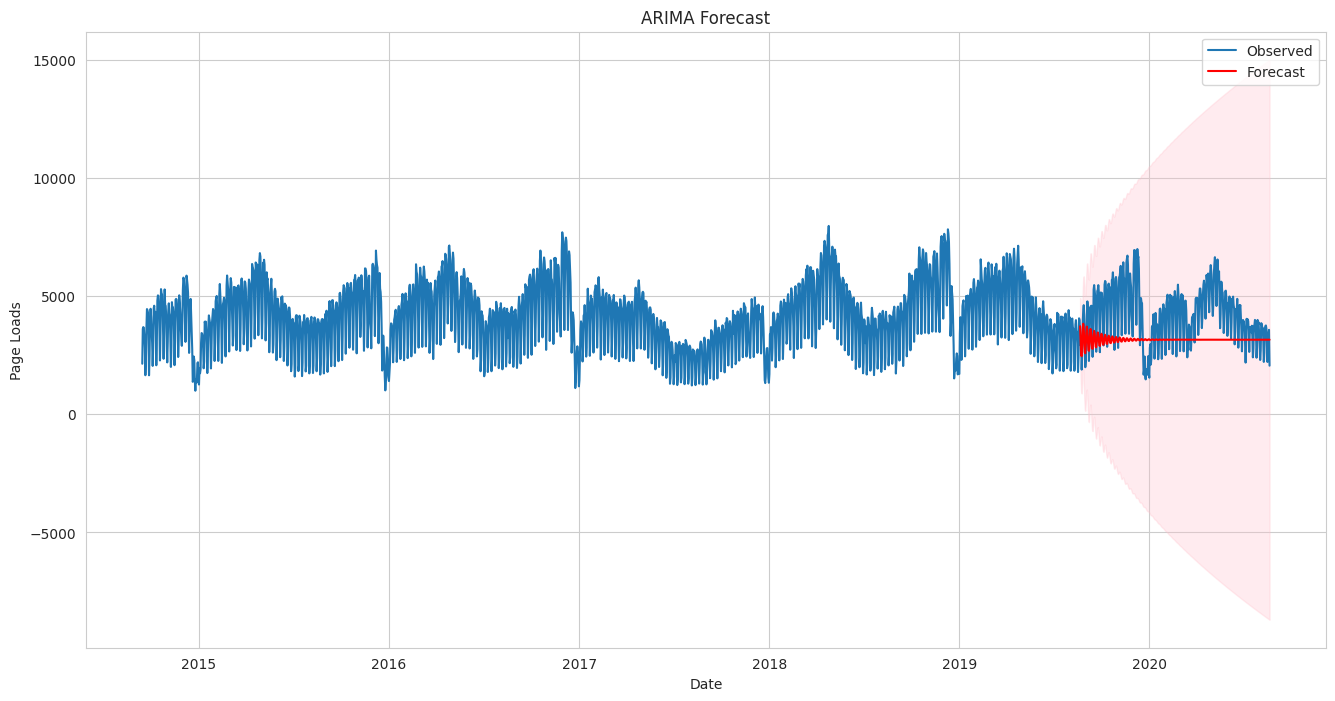

In [206]:
# Forecasting the next 365 days using the model
forecast = fitted_model.get_forecast(steps=365)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plotting the forecast and the confidence interval
plt.figure(figsize=(16, 8))
plt.plot(data['Page.Loads'].index, data['Page.Loads'], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='red', label='Forecast')
plt.fill_between(mean_forecast.index, confidence_intervals['lower Page.Loads'], confidence_intervals['upper Page.Loads'], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

In [207]:
# Assuming 'data' includes the actual observations for the last 365 days that we also forecasted
actual = data['Page.Loads'].iloc[-365:]
predicted = mean_forecast

# Calculate RMSE and MAE
arima_rmse = mean_squared_error(actual, predicted, squared=False)  # Set squared=False for RMSE
arima_mae = mean_absolute_error(actual, predicted)

# Output the evaluation metrics
print(f"Root Mean Square Error (RMSE): {arima_rmse}")
print(f"Mean Absolute Error (MAE): {arima_mae}")

Root Mean Square Error (RMSE): 1543.2007074743829
Mean Absolute Error (MAE): 1265.6078942349927


In [208]:
# Define parameter ranges for ARIMA
p = d = q = range(0, 3)

# Define ranges for seasonal components (P, D, Q)
P = D = Q = range(0, 3)
s = [12]  # Seasonal period (e.g., 12 for monthly observations)

# Generate all combinations of parameters for ARIMA and seasonal components
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# Function to fit a single combination and return the results
def fit_sarima(param, seasonal_param):
    try:
        model = SARIMAX(data['Page.Loads'], order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        return (param, seasonal_param, fitted_model.aic)
    except:
        return (param, seasonal_param, float('inf'))

# Use Parallel to fit all combinations and find the best AIC
results = Parallel(n_jobs=-1)(delayed(fit_sarima)(param, seasonal_param) for param in pdq for seasonal_param in seasonal_pdq)

# Find the best combination
best_result = min(results, key=lambda x: x[2])
best_order, best_seasonal_order, best_aic = best_result

# Output the best parameter combination found
print(f'Best SARIMA Order: {best_order} x {best_seasonal_order} - AIC:{best_aic}')

Best SARIMA Order: (2, 1, 2) x (0, 1, 2, 12) - AIC:32767.115264088632


In [209]:
# SARIMA Model setup
sarima_order = (2, 1, 2)
seasonal_order = (0, 1, 2, 12)

# Initialize and fit the SARIMA model
sarima_model = SARIMAX(data['Page.Loads'].iloc[:-365], order=sarima_order, seasonal_order=seasonal_order)
sarima_fitted = sarima_model.fit()

# Check the summary of the model to understand the fit
print(sarima_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Page.Loads   No. Observations:                 1802
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood              -13870.468
Date:                            Thu, 09 May 2024   AIC                          27754.936
Time:                                    08:20:08   BIC                          27793.361
Sample:                                09-14-2014   HQIC                         27769.124
                                     - 08-20-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2472      0.000   7219.579      0.000       1.247       1.248
ar.L2         -1.0000   5.38e-05  -

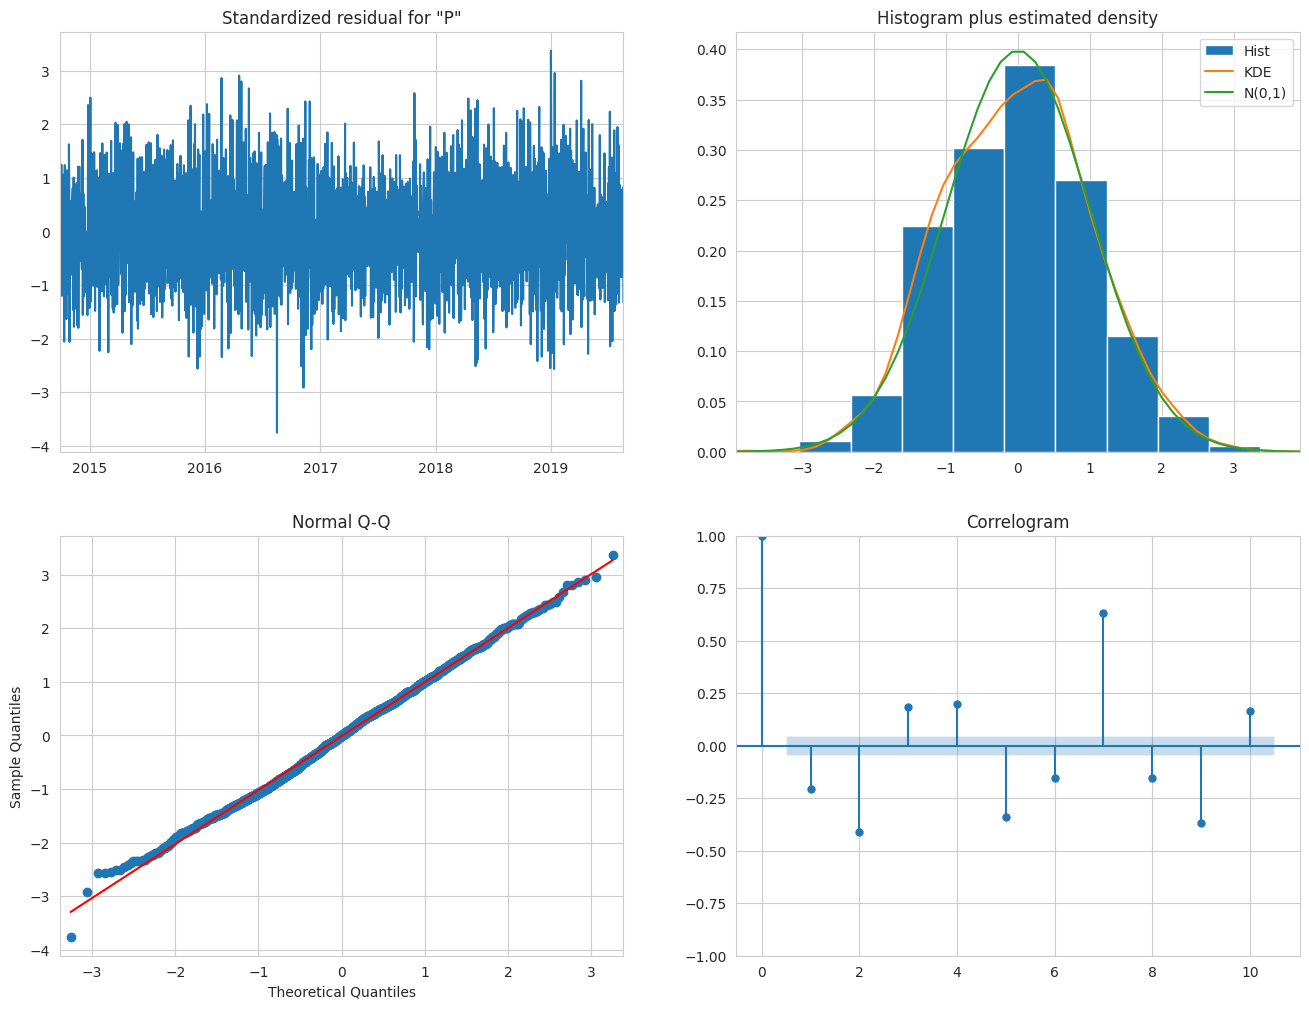

In [210]:
# Model Diagnostics to check for any unusual behavior
sarima_fitted.plot_diagnostics(figsize=(16, 12))
plt.show()

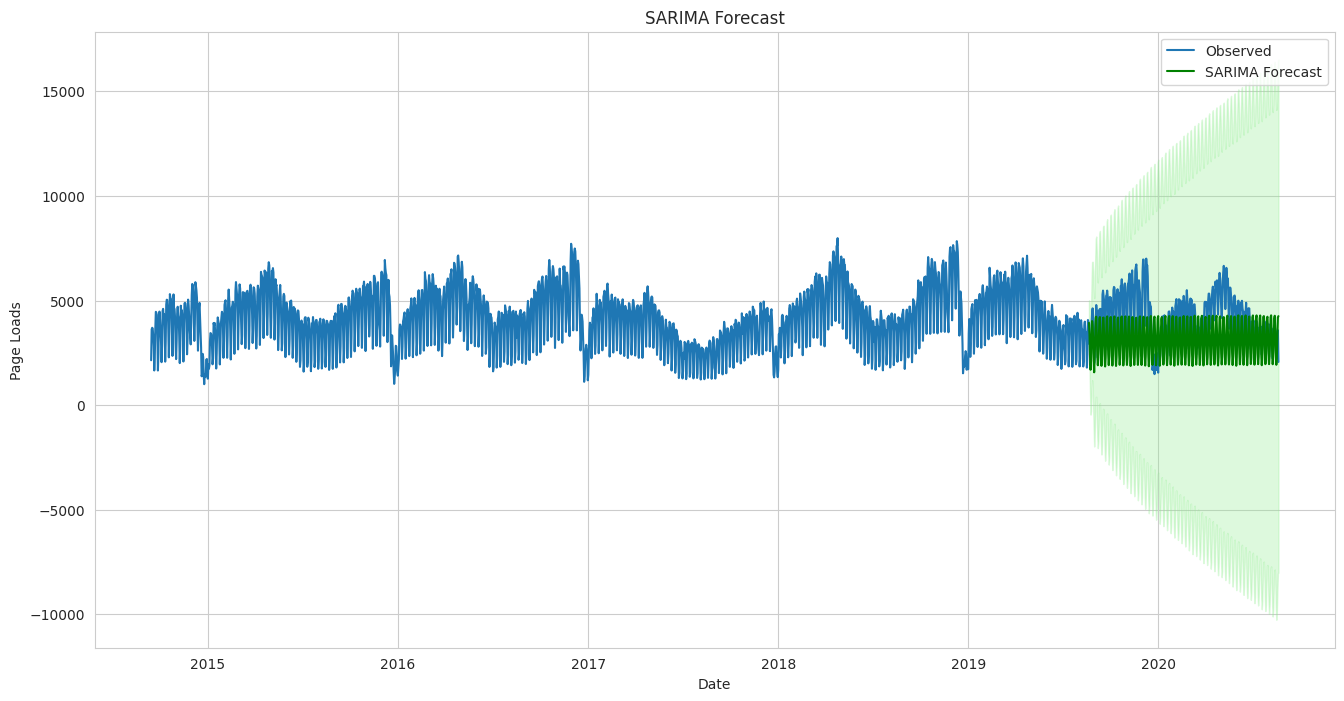

In [211]:
# Forecasting the next 365 days using SARIMA
sarima_forecast = sarima_fitted.get_forecast(steps=365)
sarima_mean = sarima_forecast.predicted_mean
sarima_conf = sarima_forecast.conf_int()

# Plotting SARIMA forecast and confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['Page.Loads'], label='Observed')
plt.plot(sarima_mean.index, sarima_mean, color='green', label='SARIMA Forecast')
plt.fill_between(sarima_mean.index, sarima_conf.iloc[:, 0], sarima_conf.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

In [212]:
# Assuming 'data' includes the actual observations for the last 365 days that we also forecasted
actual = data['Page.Loads'].iloc[-365:]
predicted = sarima_mean

# Calculate RMSE and MAE
sarima_rmse = mean_squared_error(actual, predicted, squared=False)  # Set squared=False for RMSE
sarima_mae = mean_absolute_error(actual, predicted)

# Output the evaluation metrics
print(f"Root Mean Square Error (RMSE): {sarima_rmse}")
print(f"Mean Absolute Error (MAE): {sarima_mae}")

Root Mean Square Error (RMSE): 1455.662778300626
Mean Absolute Error (MAE): 1233.166948306757


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo38tbrld/ls7v0mmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo38tbrld/4gdthwf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11406', 'data', 'file=/tmp/tmpo38tbrld/ls7v0mmp.json', 'init=/tmp/tmpo38tbrld/4gdthwf2.json', 'output', 'file=/tmp/tmpo38tbrld/prophet_model4p2khwk5/prophet_model-20240509082010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


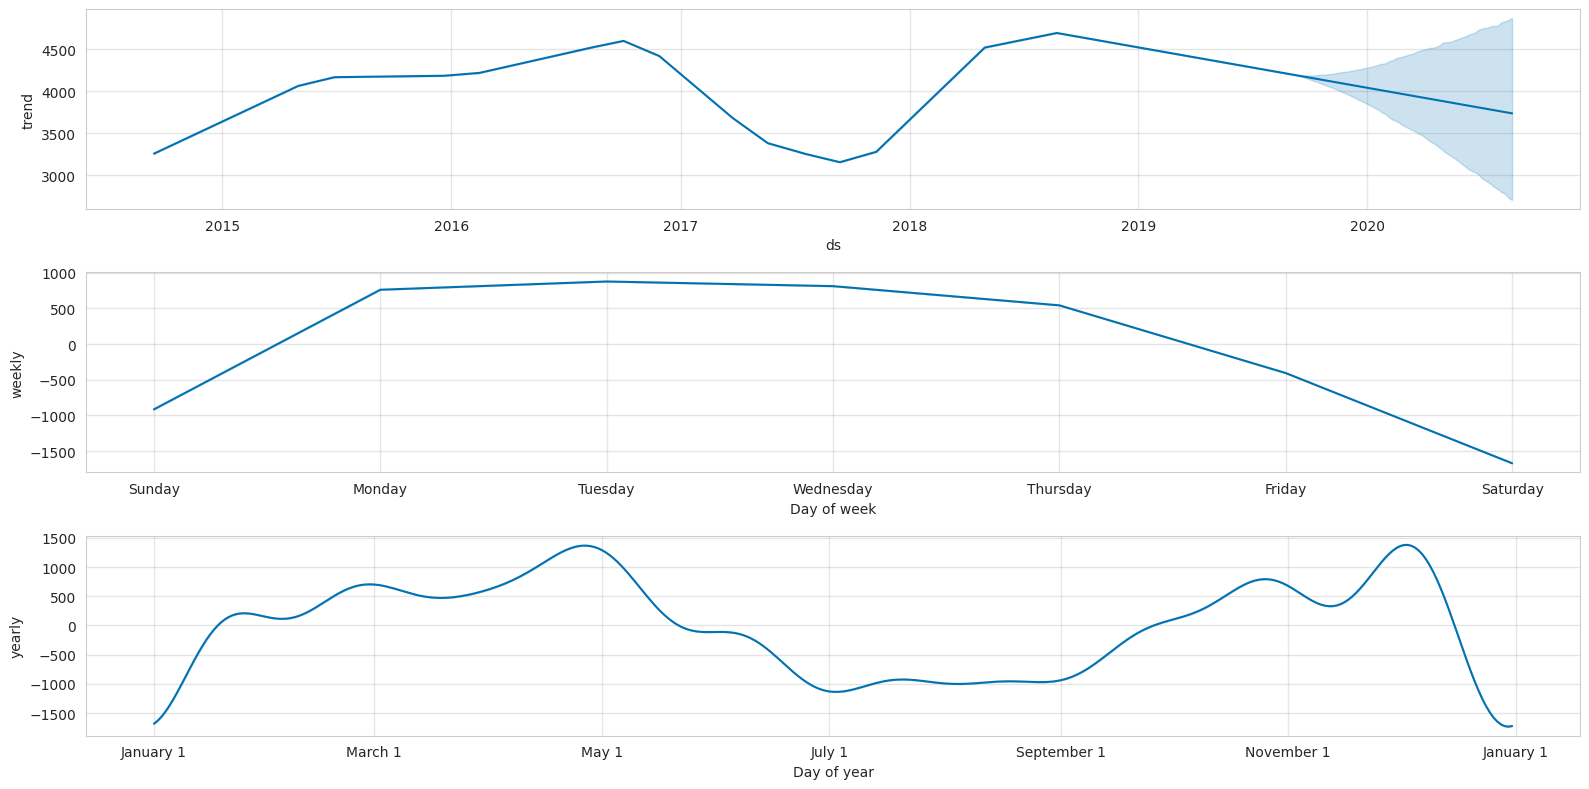

In [213]:
# Prepare the data for Prophet
prophet_data = data[['Page.Loads']].reset_index().rename(columns={'Date': 'ds', 'Page.Loads': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data.iloc[:-365])

# Make future predictions (next 365 days)
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

# Prophet Diagnostics
# Visualize seasonal and trend components with the 'plot_components' method
# Create the components plot
components_fig = prophet_model.plot_components(forecast)

# Adjust the figure size
components_fig.set_size_inches(16, 8)

# Tighten the layout
components_fig.tight_layout()
plt.show()

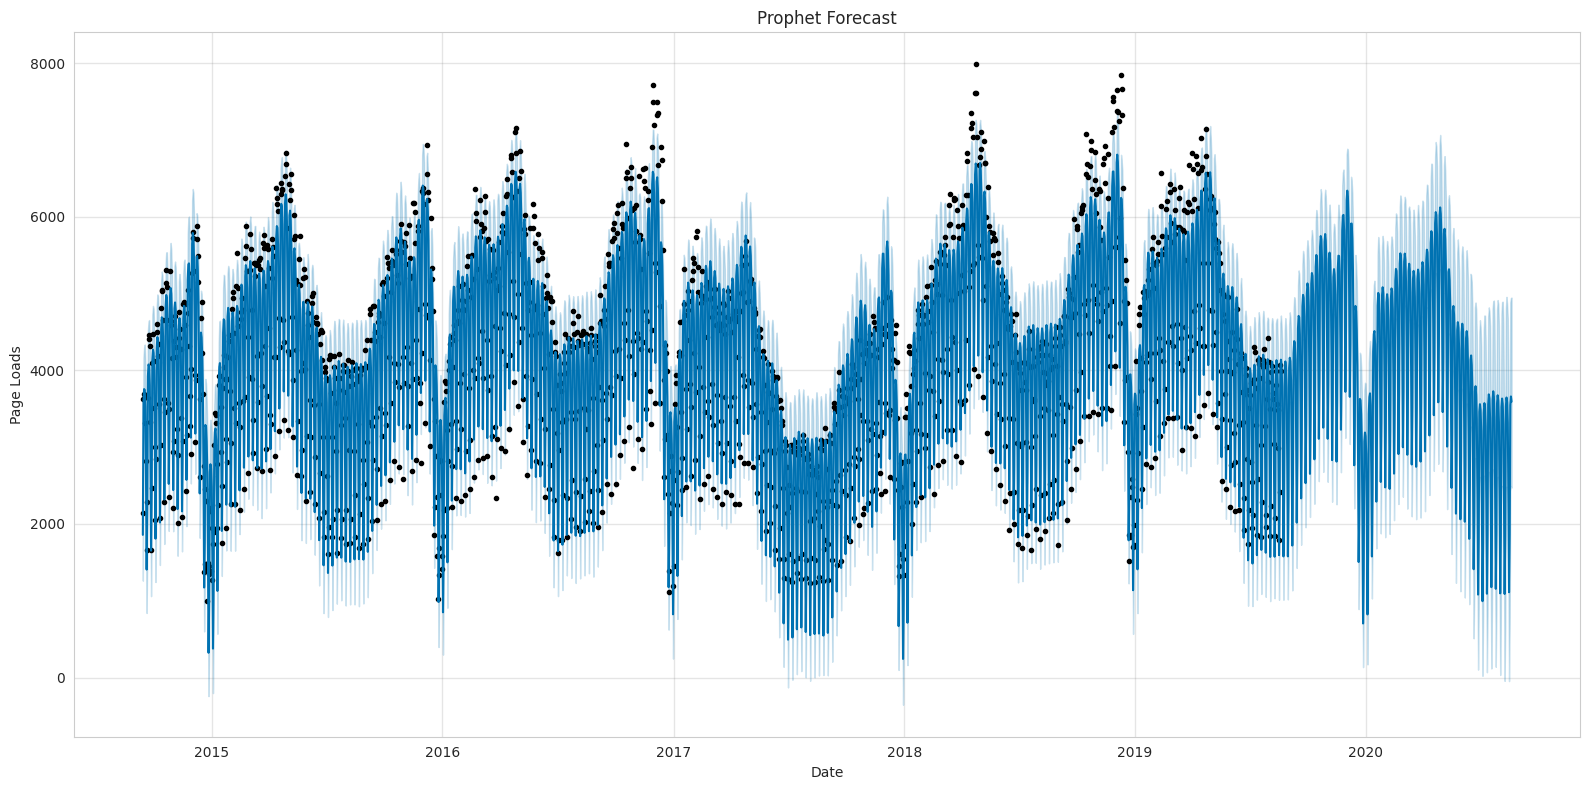

In [214]:
# Plot the forecast
forecast_fig = prophet_model.plot(forecast)

# Adjust the figure size
forecast_fig.set_size_inches(16, 8)

# Customize the plot further if needed
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Page Loads')

# Tighten the layout
forecast_fig.tight_layout()

# Show the plot
plt.show()

In [215]:
# Model Evaluation
# Assuming 'data' includes the actual observations for the last 365 days
actual = data['Page.Loads'].iloc[-365:]
predicted = forecast['yhat'].iloc[-365:]

# Calculate RMSE and MAE
prophet_rmse = mean_squared_error(actual, predicted, squared=False)  # Set squared=False for RMSE
prophet_mae = mean_absolute_error(actual, predicted)

# Output the evaluation metrics
print(f"Root Mean Square Error (RMSE): {prophet_rmse}")
print(f"Mean Absolute Error (MAE): {prophet_mae}")

Root Mean Square Error (RMSE): 683.349291909278
Mean Absolute Error (MAE): 535.9384641269132


In [216]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare data for Random Forest
X = np.arange(len(data)).reshape(-1, 1)
y = data['Page.Loads'].values

# Split into training and test sets
X_train, X_test = X[:-365], X[-365:]
y_train, y_test = y[:-365], y[-365:]

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y.reshape(-1, 1))

# Split into training and test sets
train_data = scaled_data[:-365]
test_data = scaled_data[-365:]

# Reshape the data into sequences (LSTM input)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 30  # Sequence window size
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the inputs for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Check the summary of the model to understand the fit
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                10400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [217]:
# Train the model and collect training history
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
111/111 [==============================] - 3s 10ms/step - loss: 0.0399
Epoch 2/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0261
Epoch 3/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0250
Epoch 4/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0236
Epoch 5/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0167
Epoch 6/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0085
Epoch 7/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0076
Epoch 8/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0071
Epoch 9/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0073
Epoch 10/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0064
Epoch 11/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 12/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 13/20
111/111 [===

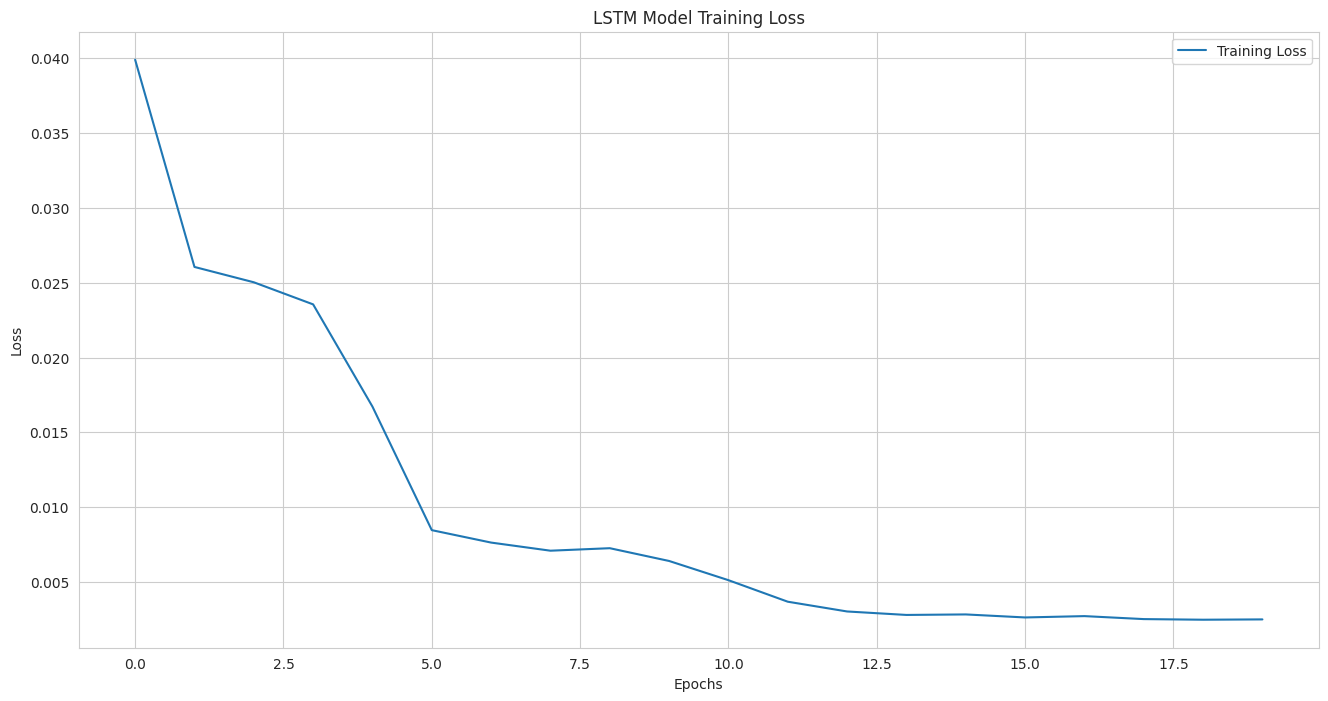

In [218]:
# Plot model diagnostics to check for any unusual behavior (training loss)
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Model Training Loss')
plt.show()

11/11 [==============================] - 0s 4ms/step


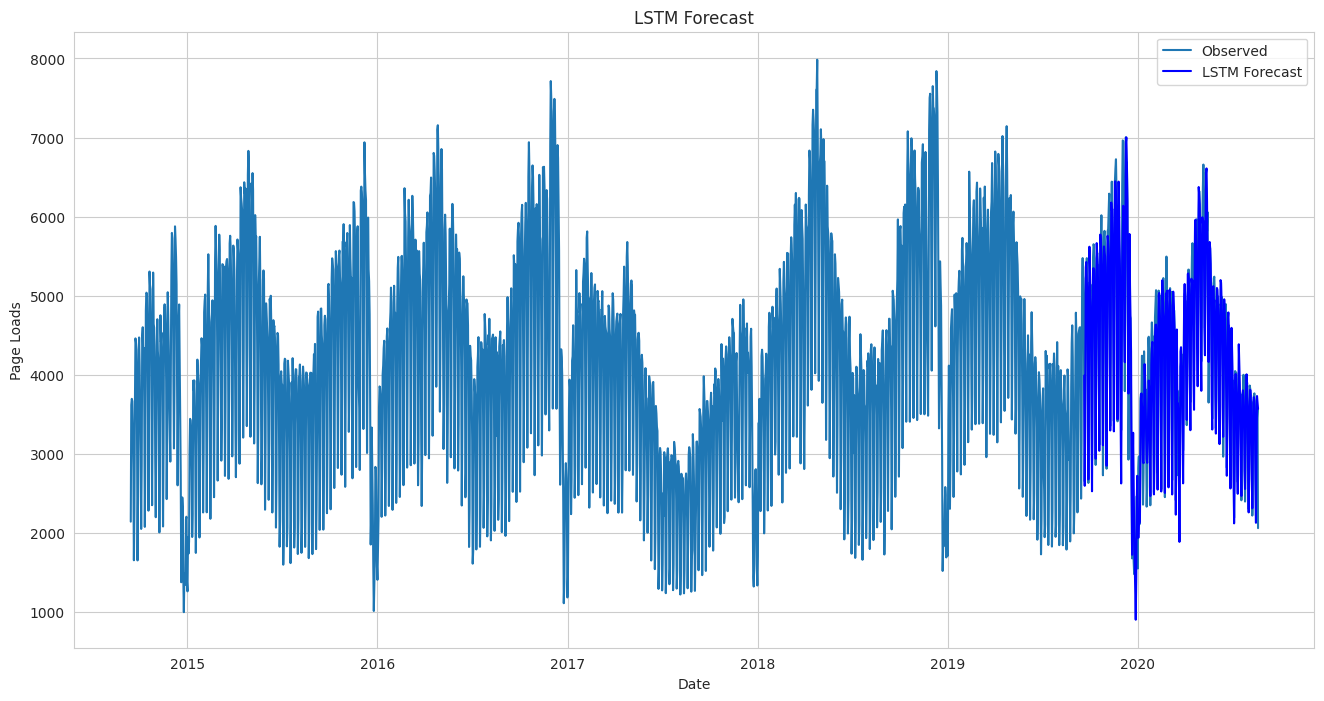

In [219]:
# Make predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plot the predictions
plt.figure(figsize=(16, 8))
plt.plot(data.index, data['Page.Loads'], label='Observed')
plt.plot(data.index[-(365 - sequence_length):], lstm_predictions, color='blue', label='LSTM Forecast')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

In [220]:
# Calculate RMSE and MAE
lstm_rmse = mean_squared_error(data['Page.Loads'].iloc[-(365 - sequence_length):], lstm_predictions, squared=False)
lstm_mae = mean_absolute_error(data['Page.Loads'].iloc[-(365 - sequence_length):], lstm_predictions)

# Output the evaluation metrics
print(f"Root Mean Square Error (RMSE): {lstm_rmse}")
print(f"Mean Absolute Error (MAE): {lstm_mae}")

Root Mean Square Error (RMSE): 408.0621377700785
Mean Absolute Error (MAE): 306.4895210835471


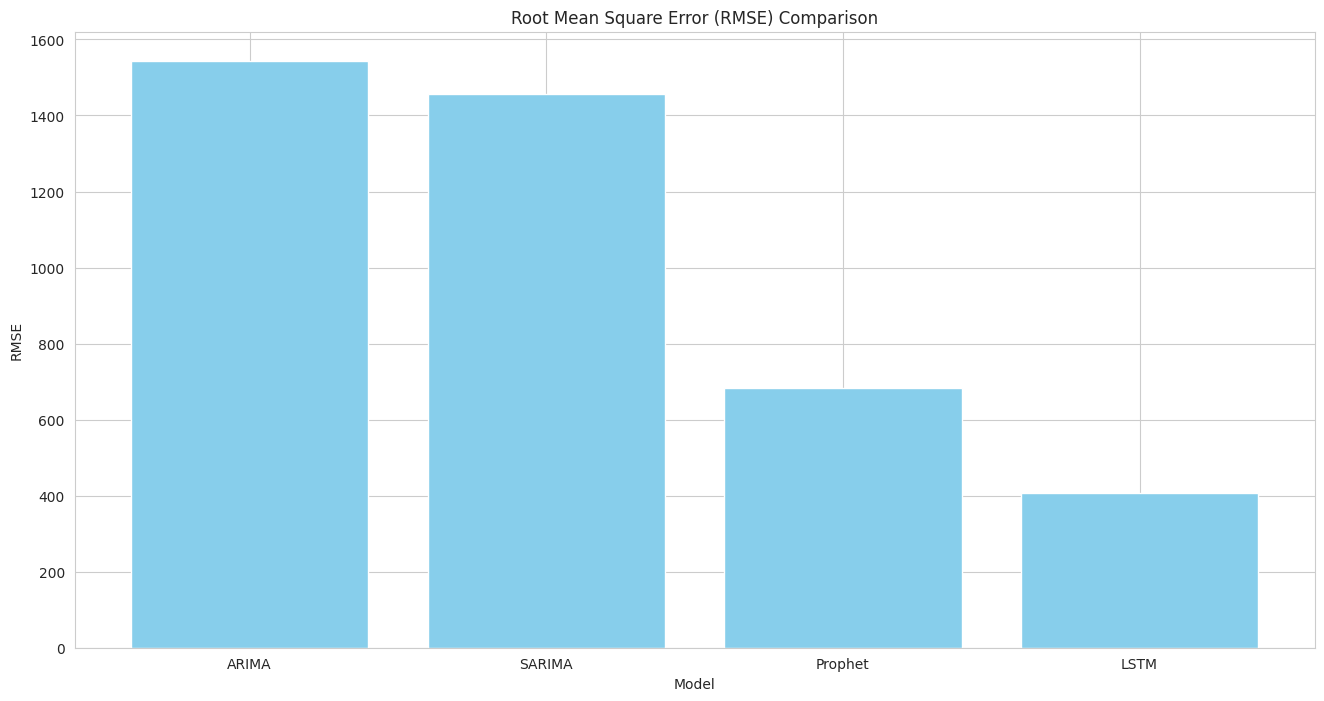

In [221]:
# Prepare the performance metrics for comparison
model_names = ['ARIMA', 'SARIMA', 'Prophet', 'LSTM']
rmse_values = [arima_rmse, sarima_rmse, prophet_rmse, lstm_rmse]
mae_values = [arima_mae, sarima_mae, prophet_mae, lstm_mae]

# Plot RMSE bar chart
plt.figure(figsize=(16, 8))
plt.bar(model_names, rmse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) Comparison')
plt.show()

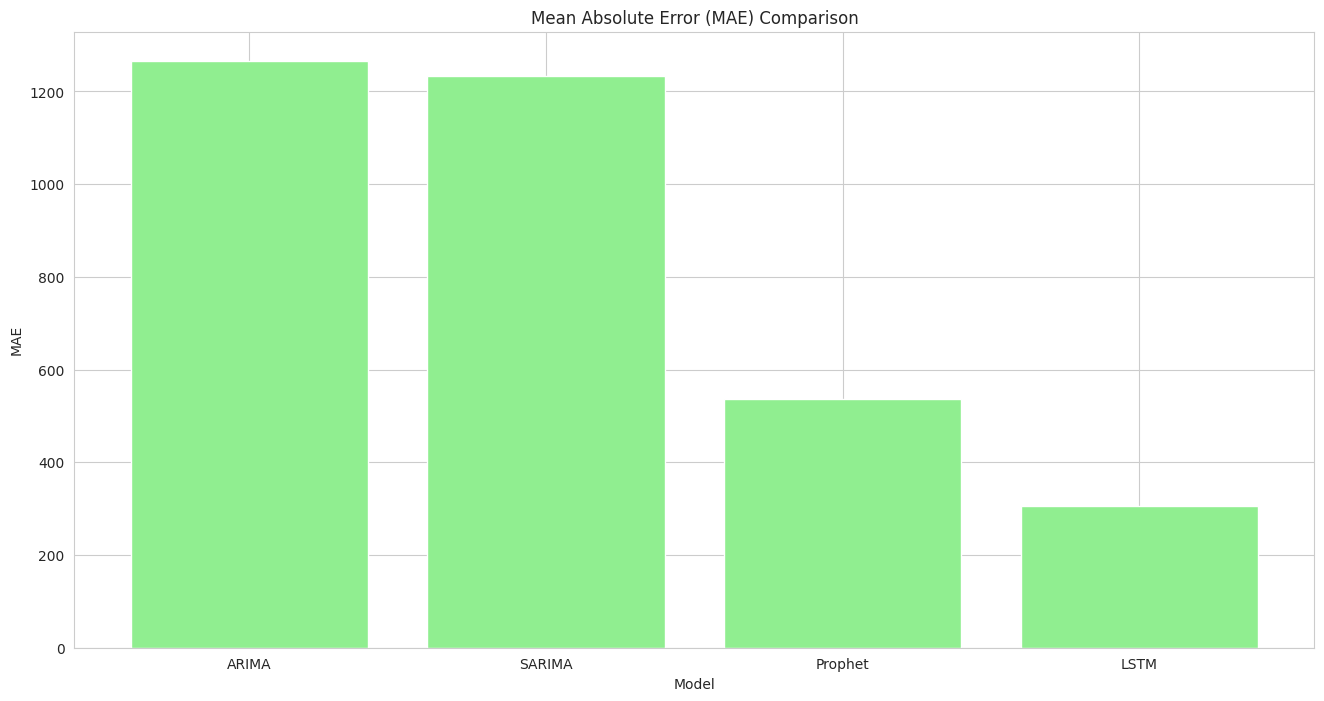

In [222]:
# Plot MAE bar chart
plt.figure(figsize=(16, 8))
plt.bar(model_names, mae_values, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.show()

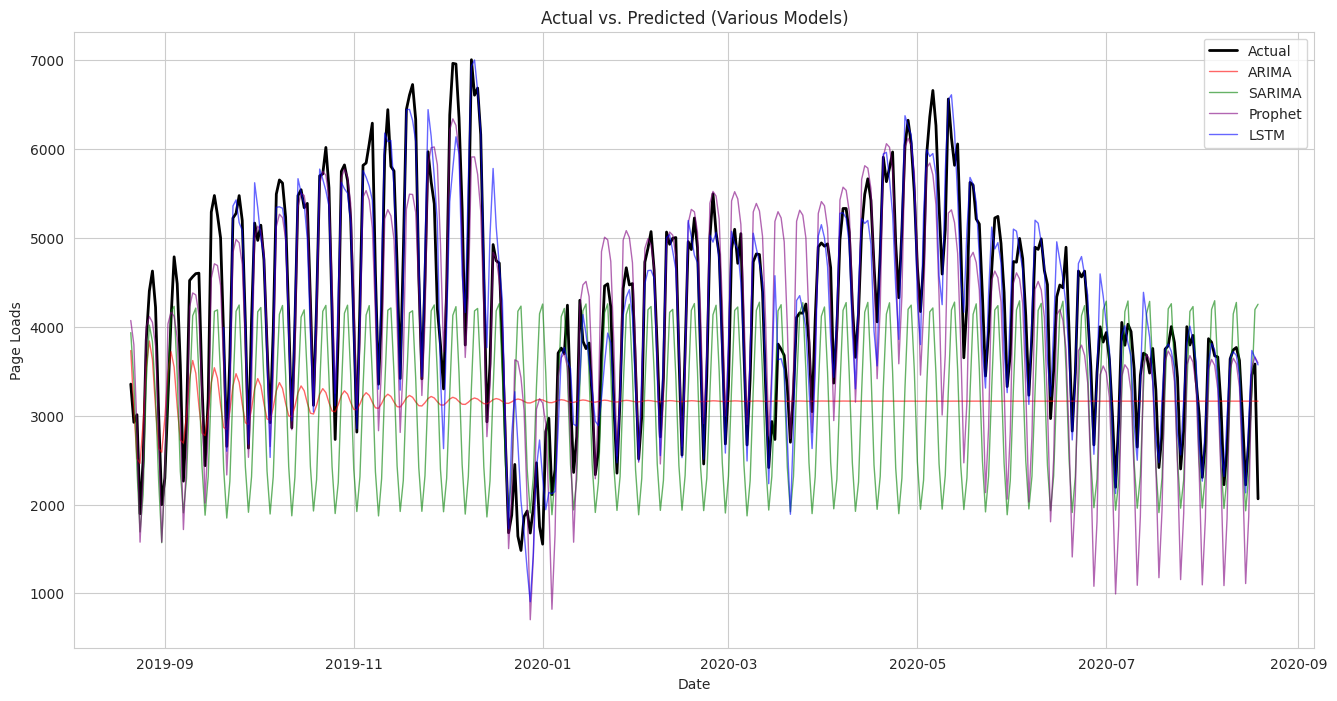

In [223]:
# Align each model's predictions with the corresponding date index
arima_index = mean_forecast.index
sarima_index = sarima_mean.index
prophet_index = forecast['ds'].iloc[-365:]
lstm_index = data.index[-(365 - sequence_length):]

# Plot actual data and predictions from each model on the same graph
plt.figure(figsize=(16, 8))
plt.plot(data.index[-365:], actual, label='Actual', color='black', linestyle='-', linewidth=2)

# Add each model's predictions
plt.plot(arima_index, mean_forecast, label='ARIMA', linestyle='-', linewidth=1, color='red', alpha=0.6)
plt.plot(sarima_index, sarima_mean, label='SARIMA', linestyle='-', linewidth=1, color='green', alpha=0.6)
plt.plot(prophet_index, forecast['yhat'].iloc[-365:], label='Prophet', linestyle='-', linewidth=1, color='purple', alpha=0.6)
plt.plot(lstm_index, lstm_predictions, label='LSTM', linestyle='-', linewidth=1, color='blue', alpha=0.6)

# Finalize plot
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Actual vs. Predicted (Various Models)')
plt.legend()
plt.show()

In [224]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize time series cross-validation object
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store cross-validated RMSE and MAE for each model
arima_rmse_cv, arima_mae_cv = [], []
sarima_rmse_cv, sarima_mae_cv = [], []
prophet_rmse_cv, prophet_mae_cv = [], []
lstm_rmse_cv, lstm_mae_cv = [], []

# ARIMA Cross-Validation
arima_order = (2, 1, 2)
for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    model = ARIMA(train['Page.Loads'], order=arima_order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test))
    rmse = mean_squared_error(test['Page.Loads'], forecast, squared=False)
    mae = mean_absolute_error(test['Page.Loads'], forecast)
    arima_rmse_cv.append(rmse)
    arima_mae_cv.append(mae)

# SARIMA Cross-Validation
sarima_order = (2, 1, 2)
seasonal_order = (0, 1, 2, 12)
for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    model = SARIMAX(train['Page.Loads'], order=sarima_order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)
    forecast = fitted_model.forecast(steps=len(test))
    rmse = mean_squared_error(test['Page.Loads'], forecast, squared=False)
    mae = mean_absolute_error(test['Page.Loads'], forecast)
    sarima_rmse_cv.append(rmse)
    sarima_mae_cv.append(mae)

# Prophet Cross-Validation
for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    prophet_train = train[['Page.Loads']].reset_index().rename(columns={'Date': 'ds', 'Page.Loads': 'y'})
    prophet_test = test[['Page.Loads']].reset_index().rename(columns={'Date': 'ds', 'Page.Loads': 'y'})
    model = Prophet()
    model.fit(prophet_train)
    future = model.make_future_dataframe(periods=len(test), include_history=False)
    forecast = model.predict(future)
    rmse = mean_squared_error(prophet_test['y'], forecast['yhat'], squared=False)
    mae = mean_absolute_error(prophet_test['y'], forecast['yhat'])
    prophet_rmse_cv.append(rmse)
    prophet_mae_cv.append(mae)

# LSTM Cross-Validation
sequence_length = 30
scaler = MinMaxScaler(feature_range=(0, 1))
for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    train_scaled = scaler.fit_transform(train[['Page.Loads']])
    test_scaled = scaler.transform(test[['Page.Loads']])

    # Create LSTM sequences
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, 0])
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled, sequence_length)
    X_test, y_test = create_sequences(test_scaled, sequence_length)
    X_train = X_train.reshape((X_train.shape[0], sequence_length, 1))
    X_test = X_test.reshape((X_test.shape[0], sequence_length, 1))

    # Build and train the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    # Forecast
    lstm_forecast = lstm_model.predict(X_test)
    lstm_forecast = scaler.inverse_transform(lstm_forecast)
    rmse = mean_squared_error(test['Page.Loads'].iloc[sequence_length:], lstm_forecast, squared=False)
    mae = mean_absolute_error(test['Page.Loads'].iloc[sequence_length:], lstm_forecast)
    lstm_rmse_cv.append(rmse)
    lstm_mae_cv.append(mae)

# Average Cross-Validation Metrics
def compute_stats(scores):
    return np.mean(scores), np.std(scores)

arima_rmse_mean, arima_rmse_std = compute_stats(arima_rmse_cv)
arima_mae_mean, arima_mae_std = compute_stats(arima_mae_cv)
sarima_rmse_mean, sarima_rmse_std = compute_stats(sarima_rmse_cv)
sarima_mae_mean, sarima_mae_std = compute_stats(sarima_mae_cv)
prophet_rmse_mean, prophet_rmse_std = compute_stats(prophet_rmse_cv)
prophet_mae_mean, prophet_mae_std = compute_stats(prophet_mae_cv)
lstm_rmse_mean, lstm_rmse_std = compute_stats(lstm_rmse_cv)
lstm_mae_mean, lstm_mae_std = compute_stats(lstm_mae_cv)

# Output Cross-Validation Results
print(f"ARIMA CV RMSE: {arima_rmse_mean:.3f} ± {arima_rmse_std:.3f}, MAE: {arima_mae_mean:.3f} ± {arima_mae_std:.3f}")
print(f"SARIMA CV RMSE: {sarima_rmse_mean:.3f} ± {sarima_rmse_std:.3f}, MAE: {sarima_mae_mean:.3f} ± {sarima_mae_std:.3f}")
print(f"Prophet CV RMSE: {prophet_rmse_mean:.3f} ± {prophet_rmse_std:.3f}, MAE: {prophet_mae_mean:.3f} ± {prophet_mae_std:.3f}")
print(f"LSTM CV RMSE: {lstm_rmse_mean:.3f} ± {lstm_rmse_std:.3f}, MAE: {lstm_mae_mean:.3f} ± {lstm_mae_std:.3f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo38tbrld/6ik2hvh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo38tbrld/8439z9sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89665', 'data', 'file=/tmp/tmpo38tbrld/6ik2hvh7.json', 'init=/tmp/tmpo38tbrld/8439z9sm.json', 'output', 'file=/tmp/tmpo38tbrld/prophet_modeli9earn1q/prophet_model-20240509082134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

11/11 [==============================] - 0s 5ms/step
ARIMA CV RMSE: 1682.948 ± 229.735, MAE: 1376.616 ± 182.935
SARIMA CV RMSE: 1949.212 ± 495.228, MAE: 1577.268 ± 405.519
Prophet CV RMSE: 2064.308 ± 1169.818, MAE: 1835.624 ± 1117.696
LSTM CV RMSE: 746.341 ± 228.102, MAE: 605.405 ± 207.181


In [225]:
# Calculate absolute errors for each model
arima_errors = abs(actual - mean_forecast)
sarima_errors = abs(actual - sarima_mean)
prophet_errors = abs(actual[-365:] - forecast['yhat'].iloc[-365:])
lstm_errors = abs(actual[-(365 - sequence_length):] - lstm_predictions.ravel())

# Perform paired t-tests
def compare_models(errors1, errors2, model1_name, model2_name):
    if len(errors1) != len(errors2):
        print(f"Error: Length mismatch between {model1_name} and {model2_name}. Skipping comparison.")
        return
    stat, p = ttest_rel(errors1, errors2)
    print(f"Comparison between {model1_name} and {model2_name}:")
    print(f"T-statistic: {stat}, P-value: {p}")
    if p < 0.05:
        print(f'Significant difference between {model1_name} and {model2_name} performance\n')
    else:
        print(f'No significant difference between {model1_name} and {model2_name} performance\n')

# Compare models
compare_models(arima_errors, sarima_errors, 'ARIMA', 'SARIMA')
compare_models(arima_errors, prophet_errors, 'ARIMA', 'Prophet')
compare_models(arima_errors, lstm_errors, 'ARIMA', 'LSTM')
compare_models(sarima_errors, prophet_errors, 'SARIMA', 'Prophet')
compare_models(sarima_errors, lstm_errors, 'SARIMA', 'LSTM')
compare_models(prophet_errors, lstm_errors, 'Prophet', 'LSTM')

Comparison between ARIMA and SARIMA:
T-statistic: 0.9012636440866912, P-value: 0.3680440884198072
No significant difference between ARIMA and SARIMA performance

Error: Length mismatch between ARIMA and Prophet. Skipping comparison.
Error: Length mismatch between ARIMA and LSTM. Skipping comparison.
Error: Length mismatch between SARIMA and Prophet. Skipping comparison.
Error: Length mismatch between SARIMA and LSTM. Skipping comparison.
Error: Length mismatch between Prophet and LSTM. Skipping comparison.
